# Comparing a USGSCSM and ISIS Camera Modal

## Prerequisites

### Knoten

An [Installation of Knoten](https://github.com/DOI-USGS/knoten/tree/main#installing) is requried.
Most imports are included in the [knoten environment](https://github.com/DOI-USGS/knoten/blob/main/environment.yml).

### ISIS
An [installation of ISIS](https://astrogeology.usgs.gov/docs/how-to-guides/environment-setup-and-maintenance/installing-isis-via-anaconda/) and [ISIS-data](https://github.com/DOI-USGS/ISIS3?tab=readme-ov-file#full-isis-data-download) are also required.

`ISISROOT` and `ISISDATA` must be set to point to your ISIS and ISIS-data installations.

In [1]:
import os

# kalasiris requires ISISROOT and ISISDATA environment variables to be set.
os.environ['ISISROOT'] = '/usr/local/Caskroom/miniconda/base/envs/isis-prod'
os.environ['ISISDATA'] = '/Volumes/usgs-data/isis-data'

import kalasiris as isis
import subprocess
import urllib.request

from knoten import vis

import json
import ale

from IPython.display import Image

import plotly
plotly.offline.init_notebook_mode(connected=True)

## Download PDS Image

In [2]:
# File Locations

url = 'https://pds-imaging.jpl.nasa.gov/data/mro/mars_reconnaissance_orbiter/ctx/mrox_3365/data/K11_057871_1602_XN_19S163W.IMG'

image_dir = 'data'
fileName = os.path.join(image_dir, os.path.basename(url))

In [3]:
# Download Files

downloader = urllib.request.URLopener()

if not os.path.isfile(fileName):
    downloader.retrieve(url, fileName)

## Ingest the image into ISIS and attach SPICE via spiceinit

In [4]:
cub_loc = os.path.splitext(fileName)[0] + '.cub'

try: 
    isis.mroctx2isis(from_=fileName, to=cub_loc)
except subprocess.CalledProcessError as e:
    print(e.stderr)

try:
    isis.spiceinit(from_=cub_loc, shape='ellipsoid')
except subprocess.CalledProcessError as e:
    print(e.stderr)

## Create an ISD from the PDS3 .IMG using ISIS cube kernels and store it next to the cube

In [ ]:
kernels = ale.util.generate_kernels_from_cube(cub_loc, expand=True)
usgscsm_str = ale.loads(fileName, props={'kernels': kernels})

csm_isd = os.path.splitext(cub_loc)[0] + '.json'
with open(csm_isd, 'w') as isd_file:
    isd_file.write(usgscsm_str)
    
usgscsm_json = json.loads(usgscsm_str)
n_lines = usgscsm_json['image_lines']
n_samples = usgscsm_json['image_samples']

In [6]:
csmisis_diff_lv_plot, csmisis_diff_ephem_plot, external_orientation_data = vis.external_orientation_diff(csm_isd, cub_loc, n_lines, n_samples, nx=10, ny=50, width=600, height=600)

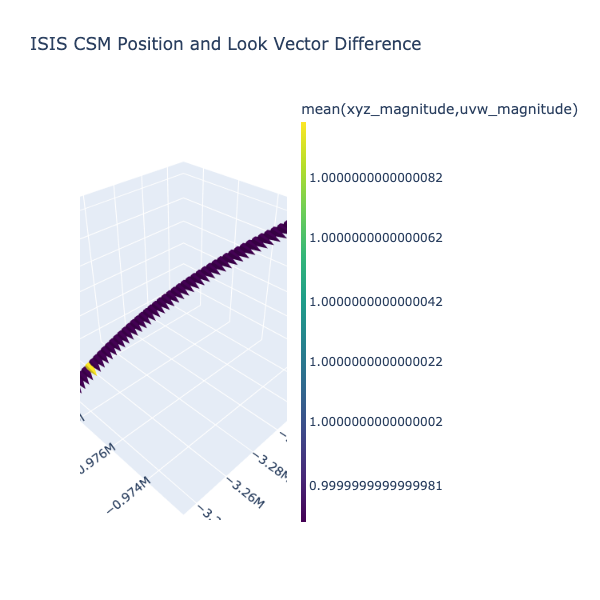

In [7]:
Image(csmisis_diff_lv_plot.to_image())

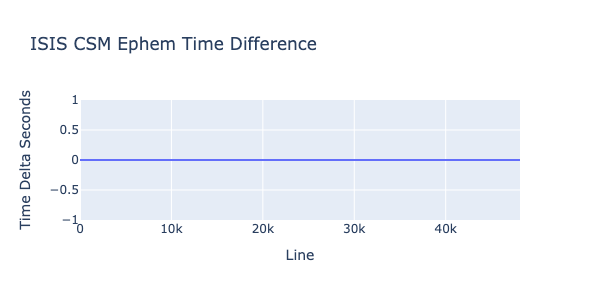

In [8]:
Image(csmisis_diff_ephem_plot.to_image())

In [9]:
external_orientation_data[['diffx', 'diffy', 'diffz', 'diffu', 'diffv', 'diffw']].describe()

,diffx,diffy,diffz,diffu,diffv,diffw
count,500.000000,5.000000e+02,500.000000,5.000000e+02,5.000000e+02,5.000000e+02
mean,0.000045,1.371485e-04,-0.000008,1.854365e-08,-1.047226e-07,3.245527e-08
std,0.000412,9.615655e-04,0.000151,1.073845e-07,3.527360e-07,3.402213e-07
min,-0.000878,-1.870836e-03,-0.000327,-2.076260e-07,-1.148931e-06,-1.022986e-06
25%,-0.000317,-5.081403e-04,-0.000135,-3.672289e-08,-3.207307e-07,-1.825518e-07
50%,0.000010,-3.917958e-07,0.000005,7.908351e-09,-3.636983e-08,2.781825e-08
75%,0.000387,9.547319e-04,0.000095,6.526615e-08,9.262571e-08,1.748479e-07
max,0.000824,1.936682e-03,0.000337,4.120192e-07,5.573533e-07,9.167857e-07


In [ ]:
isis2csm_plot, csm2isis_plot, isiscsm_plotlatlon, isiscsm_plotbf, isis2csm_data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata = vis.reprojection_diff(csm_isd, cub_loc, n_lines, n_samples, nx=10, ny=50, width=600, height=600, edge_pad=0.01)

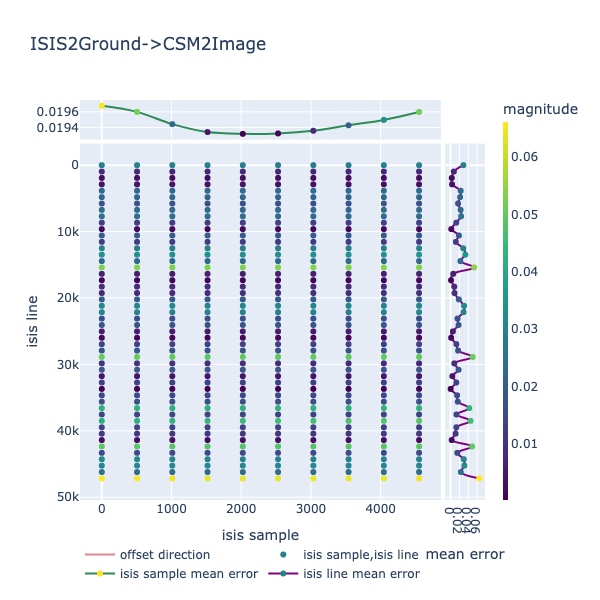

In [11]:
Image(isis2csm_plot.to_image())

In [12]:
isis2csm_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,0.000923,0.005480
std,0.014497,0.018782
min,-0.047620,-0.030066
25%,-0.007940,-0.005042
50%,0.001069,0.002039
75%,0.007042,0.016659
max,0.038984,0.062217


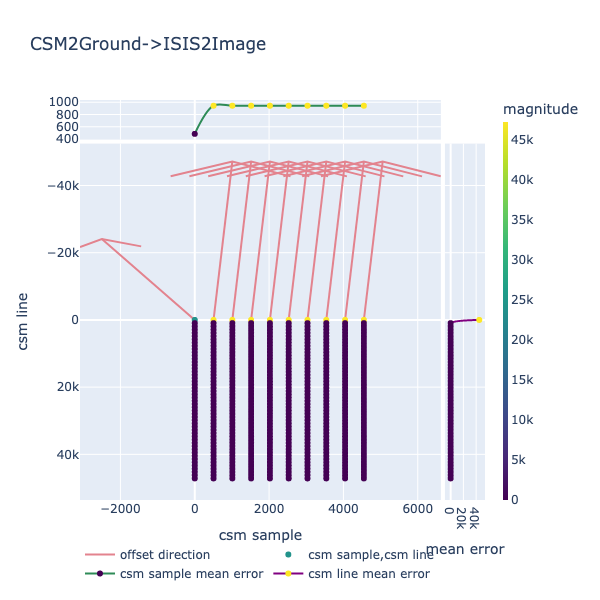

In [13]:
Image(csm2isis_plot.to_image())

In [14]:
csm2isis_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,-897.106541,4.095704
std,6362.131018,130.815174
min,-47165.462582,-2499.490000
25%,-0.007483,-0.016478
50%,-0.001220,-0.001696
75%,0.006842,0.006311
max,0.048158,505.539866


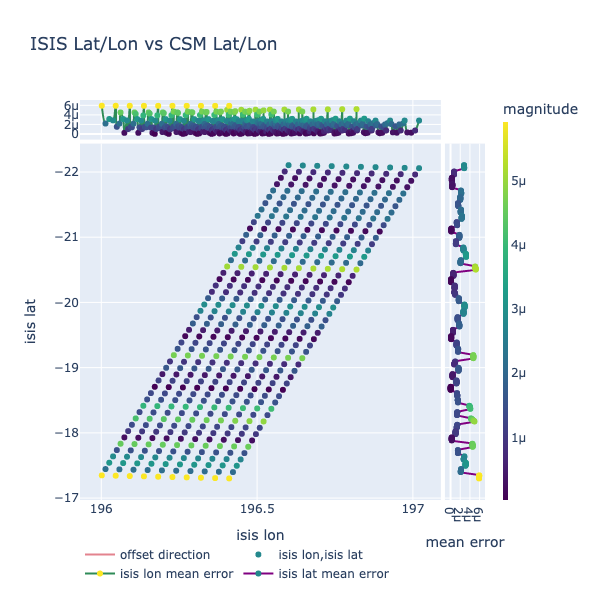

In [15]:
Image(isiscsm_plotlatlon.to_image())

In [16]:
isiscsm_latlondata[['diff lon', 'diff lat']].describe()

,diff lon,diff lat
count,5.000000e+02,5.000000e+02
mean,4.841295e-07,1.494295e-07
std,1.612976e-06,1.568358e-06
min,-2.644622e-06,-4.685121e-06
25%,-4.912371e-07,-8.470218e-07
50%,1.772866e-07,1.228222e-07
75%,1.505464e-06,8.135503e-07
max,5.175093e-06,4.323391e-06


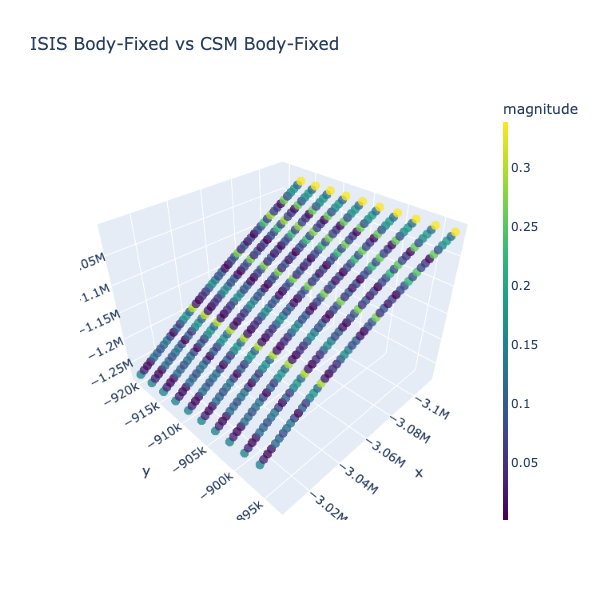

In [17]:
Image(isiscsm_plotbf.to_image())

In [18]:
isiscsm_bfdata[['diffx', 'diffy', 'diffz']].describe()

,diffx,diffy,diffz
count,500.000000,500.000000,500.000000
mean,0.139296,0.026957,-0.008280
std,1.618040,0.091217,0.087651
min,-3.020722,-0.143565,-0.239508
25%,-0.770310,-0.024299,-0.045098
50%,-0.353464,0.009894,-0.006884
75%,1.736038,0.081279,0.047135
max,3.021156,0.295423,0.263398
